# Implement a custom Autoencoder with Koopman layer

Baseline model to load in models. Please change code accordingly to load in your model...

## Version Control

To Do:
1) Account for trailing batch - Make robust (fixed issue by reshaping input data)
2) Preprocess Data
3) Make sure sim data is different for different ground parameters
4) Validation data has different batch size. Address when HP training
5) Address semi graident issue for K^m*z in linearity loss (Prob fine)

## Setup

In [2]:
import tensorflow as tf
import matplotlib as mpl
from matplotlib import pyplot as plt
from tensorflow import keras

import  numpy as np
import pandas as pd

import matplotlib.colors as mcol

import time 
import os

import glob

In [4]:
plt.rcParams['figure.figsize'] = [9, 6]
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [26]:
#from google.colab import drive
#drive.mount('/gdrive')

Comment out if don't need

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


1 Physical GPUs, 1 Logical GPUs


# Load the Model

In [5]:
new_model = tf.keras.models.load_model('doggo_Trained_Model', compile=False) # Change load checkpoint
new_model.summary()

Model: "Koopman_AE_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_model_10 (EncoderMod multiple                  8480      
_________________________________________________________________
koopman__model_10 (Koopman_M multiple                  256       
_________________________________________________________________
decoder_model_10 (DecoderMod multiple                  9700      
Total params: 18,436
Trainable params: 18,436
Non-trainable params: 0
_________________________________________________________________


## Load data

In [29]:
discrete_train = pd.read_csv('data/DiscreteSpectrumExample_train1_x.csv', sep=',', header=None).values
discrete_test =pd.read_csv('data/DiscreteSpectrumExample_test_x.csv', sep=',', header=None).values
discrete_validation = pd.read_csv('data/DiscreteSpectrumExample_val_x.csv', sep=',', header=None).values

In [30]:
trajLength = 64 #length of each trajectory in the dataset
numTraj = 4096 #total number of trajectories in the dataset
numTraj_val = 1024
batch_size = int(256) # Number of snapshots in each batch
numTraj_batch = int(batch_size/trajLength)
input_dim = 2

num_batches_train = int(trajLength*numTraj/batch_size) ## num_batches = trajLength*numTraj/batch_size 
num_batches_val = int(trajLength*numTraj_val/batch_size)

### Preprocess Data

In [31]:
# Normalize the data
min_val = tf.reduce_min(discrete_train)
max_val = tf.reduce_max(discrete_train)

discrete_train = (discrete_train - min_val) / (max_val - min_val)
discrete_validation = (discrete_validation - min_val) / (max_val - min_val)
discrete_test = (discrete_test - min_val) / (max_val - min_val)

train_data = tf.cast(discrete_train[0:batch_size*num_batches_train], tf.float32)
validation_data = tf.cast(discrete_validation[0:batch_size*num_batches_val], tf.float32)
validation_data = tf.data.Dataset.from_tensor_slices((validation_data, validation_data)).batch(batch_size)
test_data = tf.cast(discrete_test, tf.float32)

In [32]:
x_train = train_data
y_train = train_data

tf.shape(x_train)

<tf.Tensor: shape=(2,), dtype=int32, numpy=array([262144,      2])>

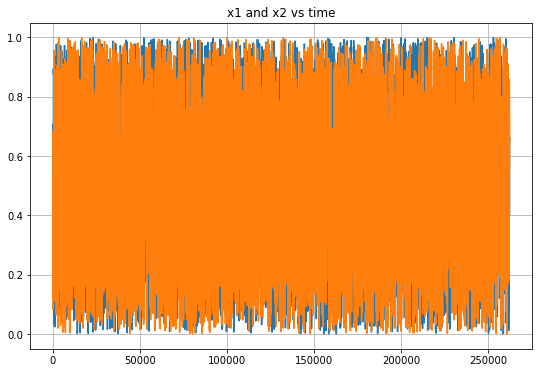

In [33]:
trail = train_data[trajLength*100:trajLength*110,:]
plt.grid()
plt.plot(x_train) #51 samples for each trajectory
plt.title("x1 and x2 vs time")
plt.show()

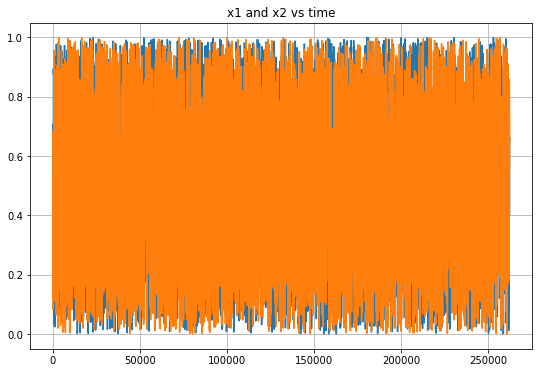

In [34]:
trail = train_data[trajLength*100:trajLength*110,:]
plt.grid()
plt.plot(x_train) #51 samples for each trajectory
plt.title("x1 and x2 vs time")
plt.show()

In [35]:
input = x_train[batch_size*10:batch_size*11]
new_out1, new_out2, new_out3 = new_model(input)

# Load data into model

In [36]:
input = x_train
new_out1, new_out2, new_out3 = new_model(input)

# Plots on Test Data

In [37]:
input = test_data[batch_size*9:batch_size*10]
new_out1, new_out2, new_out3 = new_model(input)


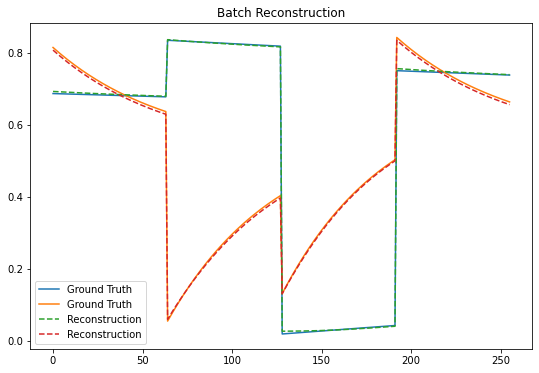

In [38]:
plt.title("Batch Reconstruction")
plt.rcParams['figure.figsize'] = [9, 6]
plt.plot(input, label = "Ground Truth")
plt.plot(new_out1, '--', label="Reconstruction")
plt.legend()

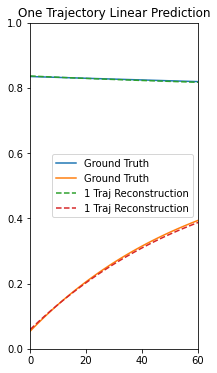

In [39]:
plt.figure(figsize=(3,6))
plt.plot(input[trajLength:trajLength*2], label = "Ground Truth")
plt.plot(new_out1[trajLength:trajLength*2], '--',label="1 Traj Reconstruction")
plt.axis([0,60,0,1])
plt.title("One Trajectory Linear Prediction")
plt.legend()

In [40]:
x = input
x2 = []
for i in range(numTraj_batch):
    x2.append(x[i*trajLength+1:(i+1)*trajLength])
x2 = tf.reshape(x2, [-1, x.shape[-1]]) # Shifted input

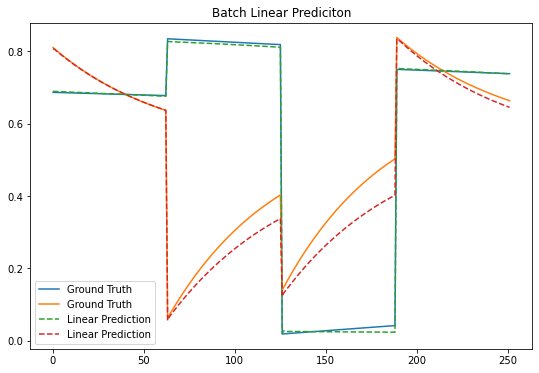

In [41]:
plt.title("Batch Linear Prediciton")
plt.rcParams['figure.figsize'] = [9, 6]
plt.plot(x2, label = "Ground Truth")
plt.plot(new_out3, '--', label="Linear Prediction")
plt.legend()

# Eigenfunction of the original system

In [42]:
K = new_model.koopman.get_weights()
print(tf.squeeze(K))

tf.Tensor(
[[ 0.04680064 -0.07271696  0.07890263 ...  0.05840349 -0.05957182
  -0.01118766]
 [-0.00346375  0.03452671  0.04423199 ...  0.01445156  0.04320152
   0.07154302]
 [-0.01876942  0.02378536  0.17800158 ... -0.1042107  -0.10070596
  -0.01008614]
 ...
 [ 0.11970284  0.00682904 -0.10966741 ... -0.00312475 -0.07961027
  -0.0906732 ]
 [-0.1888253   0.00971654 -0.0019805  ... -0.01352336 -0.01327515
   0.07654688]
 [ 0.00674055  0.00717725 -0.08447197 ...  0.03076993  0.0401029
   0.01670591]], shape=(32, 32), dtype=float32)


In [43]:
x1 = tf.linspace(-1,1,256)
x2 = tf.linspace(-1,1,256)
x1, x2 = tf.meshgrid(x1, x2)
X = tf.reshape([[x1],[x2]], [-1, 2])
print(tf.shape(X))

tf.Tensor([65536     2], shape=(2,), dtype=int32)


In [44]:
Psi1 = x1
lam = -1
mu = -0.05
b = lam/(lam-2*mu)
Psi2 = tf.Variable(x2 - tf.square(b*x1))

Text(0.5, 1.0, '$\\Psi_\\mu = x_1$')

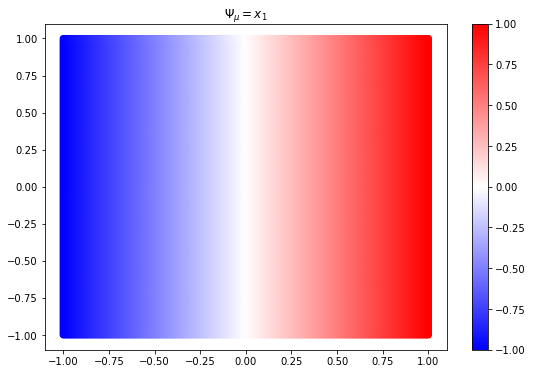

In [45]:
cm1 = mcol.LinearSegmentedColormap.from_list("MyCmapName",["b","w","r"])
normalize = mpl.colors.Normalize(vmin=np.min(Psi1), vmax=np.max(Psi1))
P1 = plt.scatter(x1, x2, c=Psi1.numpy(), norm=normalize, cmap=cm1)
plt.colorbar(P1)
plt.title('$\Psi_\mu = x_1$')

Text(0.5, 1.0, '$\\Psi_\\lambda = x_2 - bx^2_1$')

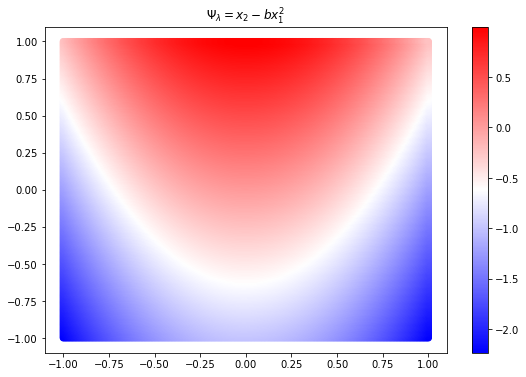

In [46]:
cm1 = mcol.LinearSegmentedColormap.from_list("MyCmapName",["b","w","r"])
normalize = mpl.colors.Normalize(vmin=np.min(Psi2), vmax=np.max(Psi2))
plt.scatter(x1, x2, c=Psi2.numpy(), norm=normalize, cmap=cm1)
plt.colorbar()
plt.title('$\Psi_\lambda = x_2 - bx^2_1$')

# Eigenfunction of Trained System